In [5]:
DATA_BASE_PATH = "/Users/mirzasharmin/Downloads/Star copy 2"

In [6]:
from src.read_data import read_all_data

patient_dfs, sinus_dfs = read_all_data(DATA_BASE_PATH)

In [7]:
from src.preprocess_data import downsample_data

downsampled_patient_dfs = downsample_data(patient_dfs, target_freq=400)
downsampled_sinus_dfs = downsample_data(sinus_dfs, target_freq=400)

In [26]:
original_patient_df = patient_dfs[list(patient_dfs.keys())[0]]
original_sinus_df = sinus_dfs[list(sinus_dfs.keys())[0]]

downsampled_patient_df = downsampled_patient_dfs[list(downsampled_patient_dfs.keys())[0]]
downsampled_sinus_df = downsampled_sinus_dfs[list(downsampled_sinus_dfs.keys())[0]]

In [9]:
len(original_patient_df), len(downsampled_sinus_df)

(93346, 14850)

In [10]:
import matplotlib.pyplot as plt
from scipy import signal

def plot_signal_comparison(original_df, downsampled_df, column_name, output_path):
    # Extract signals
    original_signal = original_df[column_name].values.squeeze()
    downsampled_signal = downsampled_df[column_name].values.squeeze()
    
    # Calculate power spectra
    f_orig, psd_orig = signal.welch(original_signal, 2_000, nperseg = 2048, window = 'boxcar')
    f_down, psd_down = signal.welch(downsampled_signal, 400, nperseg = 512, window = 'boxcar')
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(f_orig, psd_orig)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Original (2kHz)')
    plt.grid(True)
    plt.xlim(0, 500)
    
    plt.subplot(1, 2, 2)
    plt.plot(f_down, psd_down)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Downsampled (400Hz)')
    plt.grid(True)
    plt.xlim(0, 200)
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

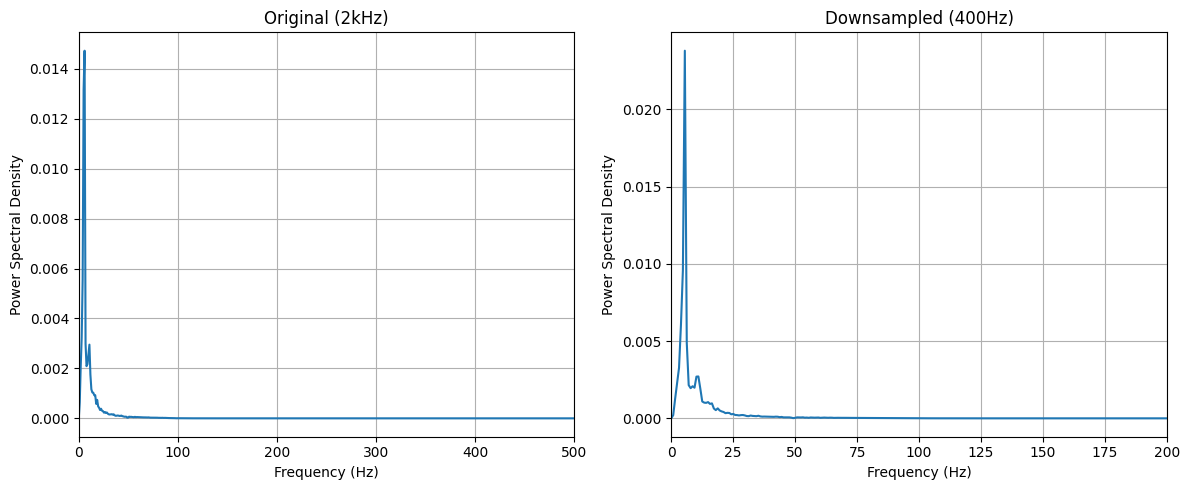

In [11]:
plot_signal_comparison(original_patient_df, downsampled_patient_df, 'c1', 'figures/patient_spectrogram.png')

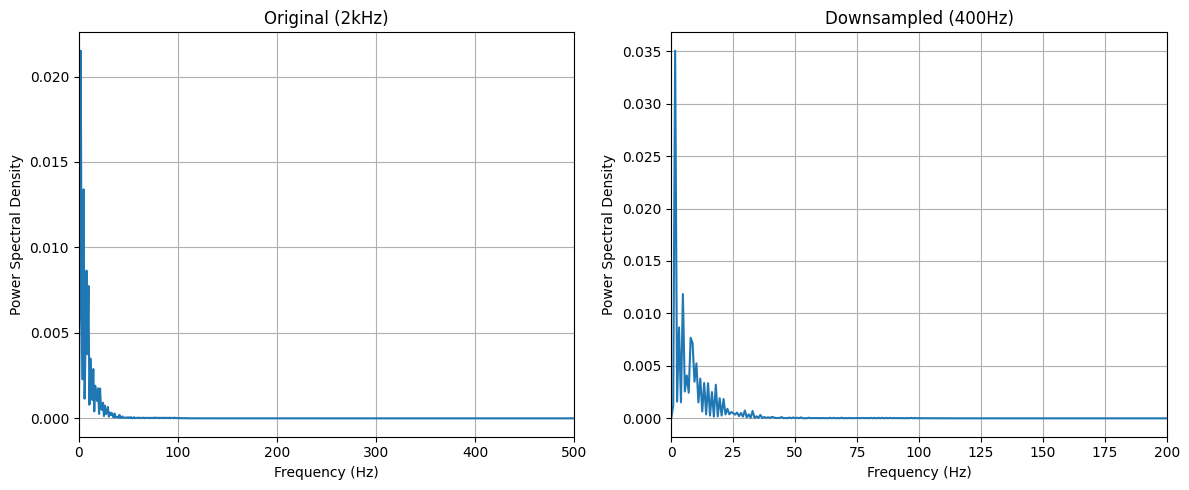

In [12]:
plot_signal_comparison(original_sinus_df, downsampled_sinus_df, 'c1', 'figures/sinus_spectrogram.png')

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def compute_fft_spectrum(X, Fs):
    """
    Compute single-sided amplitude spectrum using Eleanna's method
    """
    # Discrete Fourier transform
    Y = np.fft.fft(X)
    L = len(X)
    
    # Compute single-sided spectrum
    P2 = np.abs(Y/L)
    P1 = P2[0:int(np.floor(L/2)) + 1]  # Eleanna's modification
    P1[1:-1] = 2 * P1[1:-1]  # Double the amplitude (except DC and Nyquist)
    
    # Frequency vector
    f = Fs * np.arange(0, L//2 + 1) / L
    
    return f, P1

def plot_signal_comparison_fft(original_df, downsampled_df, column_name, output_path):
    # Extract signals
    original_signal = original_df[column_name].values.squeeze()
    downsampled_signal = downsampled_df[column_name].values.squeeze()
    
    # Calculate FFT spectra using Eleanna's method
    f_orig, spectrum_orig = compute_fft_spectrum(original_signal, 2000)
    f_down, spectrum_down = compute_fft_spectrum(downsampled_signal, 400)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(f_orig, spectrum_orig)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|P1(f)|')
    plt.title('Original (2kHz)')
    plt.grid(True)
    plt.xlim(0, 500)
    
    plt.subplot(1, 2, 2)
    plt.plot(f_down, spectrum_down)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|P1(f)|')
    plt.title('Downsampled (400Hz)')
    plt.grid(True)
    plt.xlim(0, 200)
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

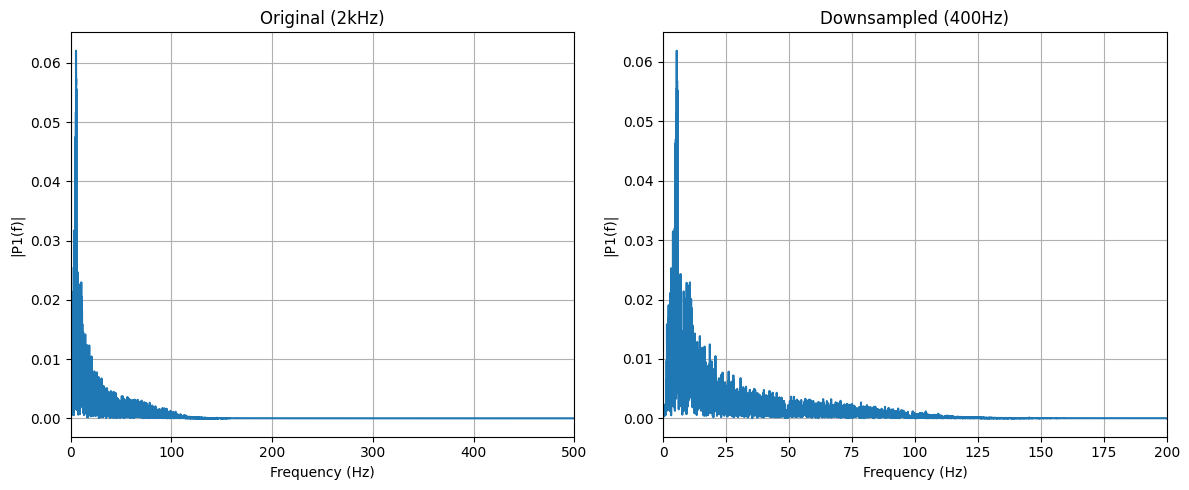

In [14]:
plot_signal_comparison_fft(original_patient_df, downsampled_patient_df, 'c1', 'figures/patient_spectrogram_fft.png')

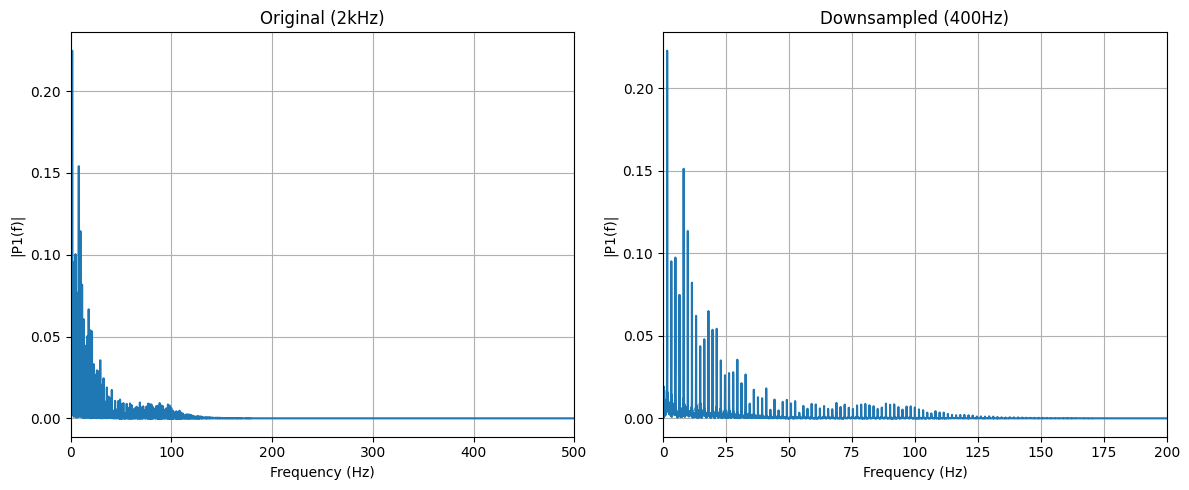

In [15]:
plot_signal_comparison_fft(original_sinus_df, downsampled_sinus_df, 'c1', 'figures/sinus_spectrogram_fft.png')

In [16]:
def plot_all_32_spectra(df, sampling_rate=400, output_path=None, title_prefix="FFT Spectra"):
    # Get last 32 columns
    columns_to_plot = df.columns[-32:]  # Last 32 columns
    
    # Create 16x2 subplot grid
    fig, axes = plt.subplots(16, 2, figsize=(15, 60))
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten()
    
    # Calculate frequency limit based on Nyquist
    xlim_max = sampling_rate // 2
    
    # Plot each column's spectrum
    for i, col_name in enumerate(columns_to_plot):
        ax = axes_flat[i]
        
        # Extract signal
        signal_data = df[col_name].values.squeeze()
        
        # Calculate FFT spectrum using Eleanna's method
        f, spectrum = compute_fft_spectrum(signal_data, sampling_rate)
        
        # Plot spectrum
        ax.plot(f, spectrum, 'b-', linewidth=0.8)
        ax.set_title(col_name, fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, xlim_max)
        
        # Set labels only for edge plots to reduce clutter
        if i >= 30:  # Bottom row
            ax.set_xlabel('Frequency (Hz)', fontsize=8)
        if i % 2 == 0:  # Left column
            ax.set_ylabel('|P1(f)|', fontsize=8)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [35]:
def plot_signal_comparison_fft(sinus_df, patient_df, column_name, output_path):
    # Extract signals
    sinus_signal = sinus_df[column_name].values.squeeze()
    patient_signal = patient_df[column_name].values.squeeze()
    
    # Calculate FFT spectra using Eleanna's method
    f_sinus, spectrum_sinus = compute_fft_spectrum(sinus_signal, 2000)
    f_patient, spectrum_patient = compute_fft_spectrum(patient_signal, 2000)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(f_sinus, spectrum_sinus)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|P1(f)|')
    plt.title('Sinus')
    plt.grid(True)
    plt.xlim(0, 300)
    
    plt.subplot(1, 2, 2)
    plt.plot(f_patient, spectrum_patient)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|P1(f)|')
    plt.title('Patient')
    plt.grid(True)
    plt.xlim(0, 300)
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

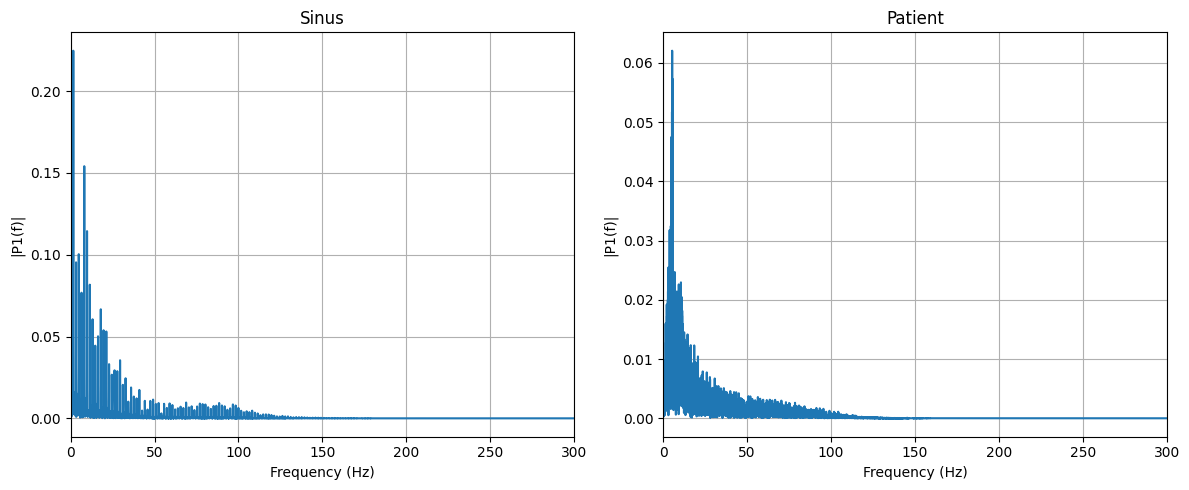

In [36]:
plot_signal_comparison_fft(original_sinus_df, original_patient_df, 'c1', 'figures/spectrum_comparison_sinus_vs_patient.png')